# CVE Growth

In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import seaborn as sns
from itables import init_notebook_mode, show
import itables.options as opt

opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [2]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = '' 
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
Year_2025 = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2026-01-01'))
Year_2024 = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
Year_2023 = ((nvd['Published'] > '2023-01-01') & (nvd['Published']  < '2024-01-01'))
Year_2022 = ((nvd['Published'] > '2022-01-01') & (nvd['Published']  < '2023-01-01'))
Year_2021 = ((nvd['Published'] > '2021-01-01') & (nvd['Published']  < '2022-01-01'))
Year_2020 = ((nvd['Published'] > '2020-01-01') & (nvd['Published']  < '2021-01-01'))

nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);

nvd_2025 = nvd.loc[Year_2025]
nvd_2025 = nvd_2025.sort_values(by=['Published'])
nvd_2025 = nvd_2025.reset_index(drop=True)
nvdcount_2025 = nvd_2025['Published'].count()

nvd_2024 = nvd.loc[Year_2024]
nvd_2024 = nvd_2024.sort_values(by=['Published'])
nvd_2024 = nvd_2024.reset_index(drop=True)
nvdcount_2024 = nvd_2024['Published'].count()

nvd_2023 = nvd.loc[Year_2023]
nvd_2023 = nvd_2023.sort_values(by=['Published'])
nvd_2023 = nvd_2023.reset_index(drop=True)
nvdcount_2023 = nvd_2023['Published'].count()

nvd_2022 = nvd.loc[Year_2022]
nvd_2022 = nvd_2022.sort_values(by=['Published'])
nvd_2022 = nvd_2022.reset_index(drop=True)
nvdcount_2022 = nvd_2022['Published'].count()

nvd_2021 = nvd.loc[Year_2021]
nvd_2021 = nvd_2021.sort_values(by=['Published'])
nvd_2021 = nvd_2021.reset_index(drop=True)
nvdcount_2021 = nvd_2021['Published'].count()

nvd_2020 = nvd.loc[Year_2020]
nvd_2020 = nvd_2020.sort_values(by=['Published'])
nvd_2020 = nvd_2020.reset_index(drop=True)
nvdcount_2020 = nvd_2020['Published'].count()


In [3]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

In [4]:
yg_df = pd.DataFrame(Year_Graph)
yg_df.columns = ['Count']
yg_df = yg_df.reset_index()
yg_df['Percentage Of CVEs'] = ( yg_df['Count'] / 
                       yg_df['Count'].sum()) * 100
yg_df['Growth YOY'] = yg_df['Count'].pct_change()*100
yg_df = yg_df.round(2)
yg_df = yg_df.rename(columns={"Count": "CVEs"})
show(yg_df, scrollY="400px", scrollCollapse=True, paging=False)

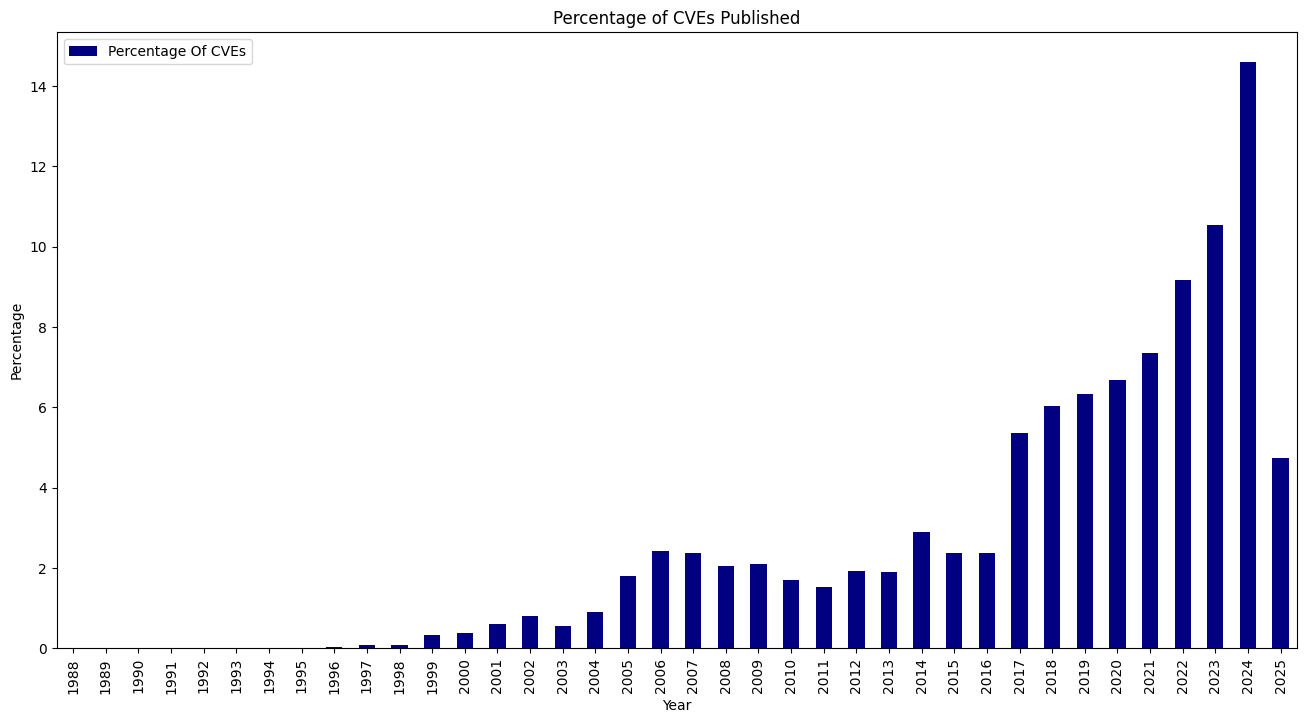

In [5]:
cg = yg_df.plot.bar(x='Published', y='Percentage Of CVEs', colormap='jet', figsize=(16, 8), title='Percentage of CVEs Published')
cg.set_ylabel("Percentage");
cg.set_xlabel("Year");

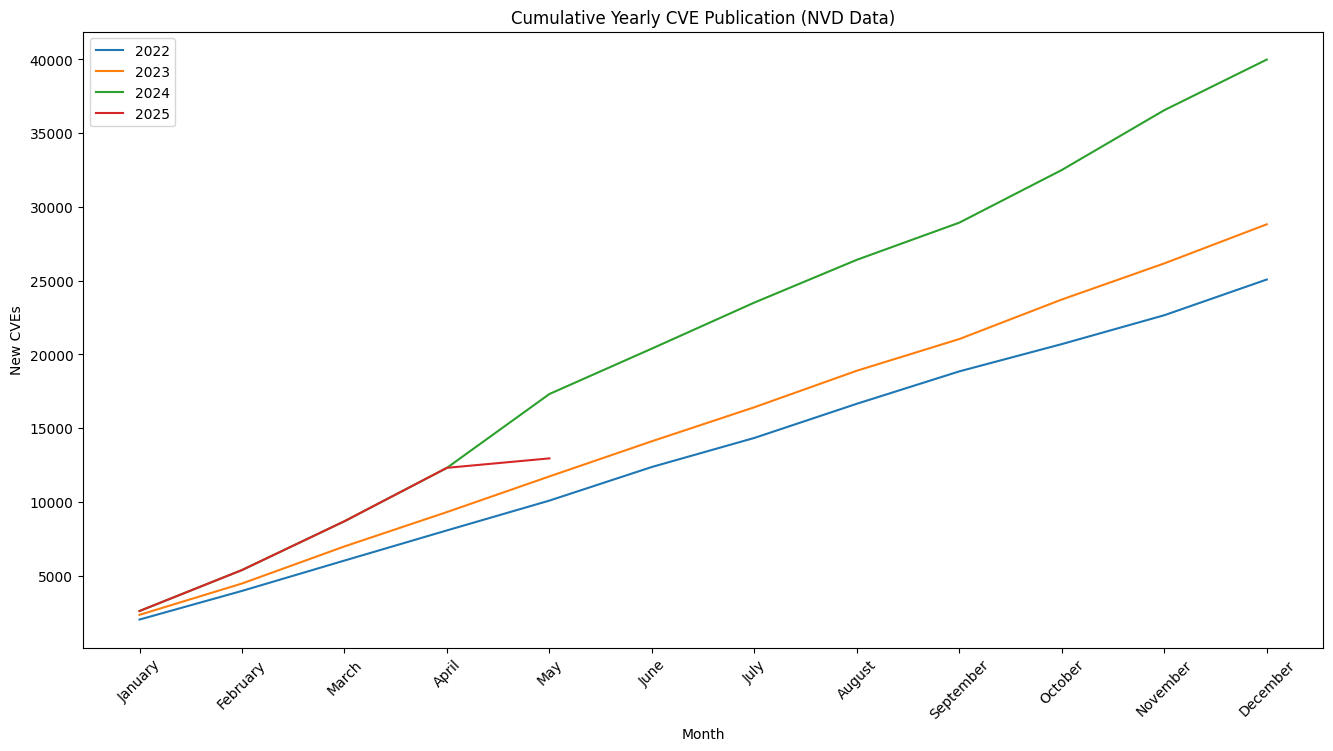

In [6]:
Month_2020 = nvd_2020['Published'].groupby(nvd_2020.Published.dt.to_period("M")).agg('count')
Month_2021 = nvd_2021['Published'].groupby(nvd_2021.Published.dt.to_period("M")).agg('count')
Month_2022 = nvd_2022['Published'].groupby(nvd_2022.Published.dt.to_period("M")).agg('count')
Month_2023 = nvd_2023['Published'].groupby(nvd_2023.Published.dt.to_period("M")).agg('count') 
Month_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
Month_2025 = nvd_2025['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')

Month_2020 = Month_2020.reset_index(name="2020")
Month_2020 = Month_2020.rename(columns={"Published": "Month"}, errors="raise")
Month_2020['Month'] = Month_2020['Month'].dt.strftime('%B')

Month_2021 = Month_2021.reset_index(name="2021")
Month_2021 = Month_2021.rename(columns={"Published": "Month"}, errors="raise")
Month_2021['Month'] = Month_2021['Month'].dt.strftime('%B')

Month_2022 = Month_2022.reset_index(name="2022")
Month_2022 = Month_2022.rename(columns={"Published": "Month"}, errors="raise")
Month_2022['Month'] = Month_2022['Month'].dt.strftime('%B')

Month_2023 = Month_2023.reset_index(name="2023")
Month_2023 = Month_2023.rename(columns={"Published": "Month"}, errors="raise")
Month_2023['Month'] = Month_2023['Month'].dt.strftime('%B')

Month_2024 = Month_2024.reset_index(name="2024")
Month_2024 = Month_2024.rename(columns={"Published": "Month"}, errors="raise")
Month_2024['Month'] = Month_2024['Month'].dt.strftime('%B')

Month_2025 = Month_2025.reset_index(name="2025")
Month_2025 = Month_2025.rename(columns={"Published": "Month"}, errors="raise")
Month_2025['Month'] = Month_2025['Month'].dt.strftime('%B')

Months = pd.merge(Month_2022, Month_2023, how='left')
Months = pd.merge(Months, Month_2024, how='left')
Months = pd.merge(Months, Month_2025, how='left')

cg = Months.cumsum().plot( figsize=(16, 8), title='Cumulative Yearly CVE Publication (NVD Data)', stacked=False)
plt.grid()
cg.grid(False)
cg.set_ylabel("New CVEs");
cg.set_xlabel("Month");
x1 = [0,1,2,3,4,5,6,7,8,9,10,11]
squad = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
cg.set_xticks(x1);
cg.set_xticklabels(squad, minor=False, rotation=45);